In [1]:
from datasets import load_dataset

#加载数据集
facades = load_dataset('lansinuote/gen.3.facades', split='train')

#切分训练和测试集
facades = facades.train_test_split(test_size=15)

facades

Using custom data configuration lansinuote--gen.3.facades-465e0f0fe7cb5151
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.3.facades-465e0f0fe7cb5151/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


DatasetDict({
    train: Dataset({
        features: ['a', 'b'],
        num_rows: 591
    })
    test: Dataset({
        features: ['a', 'b'],
        num_rows: 15
    })
})

In [2]:
import random
import torch
import torchvision


#数据集包装类
class Dataset(torch.utils.data.Dataset):

    def __init__(self, part):
        super().__init__()

        self.dataset = facades[part]

        self.to_tensor = torchvision.transforms.ToTensor()

        self.resize = torchvision.transforms.Resize(
            size=286,
            interpolation=torchvision.transforms.functional.InterpolationMode.
            BICUBIC)

        self.norm = torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))

        self.flip = torchvision.transforms.RandomHorizontalFlip(p=1)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        a = self.dataset[idx]['a']
        b = self.dataset[idx]['b']

        a = self.resize(a)
        b = self.resize(b)

        a = self.to_tensor(a)
        b = self.to_tensor(b)

        #因为裁剪时要对两张图应用同样的偏移量,所以不能用torchvision.transforms.RandomCrop
        #torchvision.transforms.RandomCrop不能批处理
        w = random.randint(0, 29)
        h = random.randint(0, 29)
        a = a[:, h:h + 256, w:w + 256]
        b = b[:, h:h + 256, w:w + 256]

        a = self.norm(a)
        b = self.norm(b)

        #同样的,要翻转就一起翻转
        if random.random() < 0.5:
            a = self.flip(a)
            b = self.flip(b)

        #交换顺序,改变计算方向
        return b, a


dataset = Dataset('train')

a, b = dataset[0]

len(dataset), a.shape, b.shape

(591, torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [3]:
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=1,
                                     shuffle=True)

a, b = next(iter(loader))

len(loader), a.shape, b.shape

(591, torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

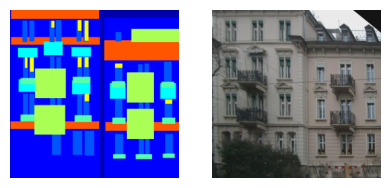

In [4]:
def show(images):
    from matplotlib import pyplot as plt

    images = images.to('cpu').detach().numpy()
    images = images[:12]
    images = images * 0.5 + 0.5
    images = images.transpose(0, 2, 3, 1)

    plt.figure(figsize=(10, 7))
    for i in range(len(images)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()


show(torch.cat((a, b)))

In [5]:
cls = torch.nn.Sequential(
    torch.nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
)

cls(torch.randn(1, 6, 256, 256)).shape

torch.Size([1, 1, 30, 30])

In [6]:
class Res(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.s = torch.nn.Sequential(
            torch.nn.ReflectionPad2d(1),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=0, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True),
            torch.nn.ReflectionPad2d(1),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=0, bias=False),
            torch.nn.BatchNorm2d(256),
        )

    def forward(self, x):
        out = x + self.s(x)
        return torch.nn.ReLU(True)(out)


Res()(torch.randn(1, 256, 64, 64)).shape

torch.Size([1, 256, 64, 64])

In [7]:
gen = torch.nn.Sequential(
    #in
    torch.nn.Sequential(
        torch.nn.ReflectionPad2d(3),
        torch.nn.Conv2d(3, 64, kernel_size=7, padding=0, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
    ),
    #down
    torch.nn.Sequential(
        torch.nn.Conv2d(64,
                        128,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        bias=False),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128,
                        256,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        bias=False),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
    ),
    #middle
    torch.nn.Sequential(*[Res() for _ in range(9)]),
    #up
    torch.nn.Sequential(
        torch.nn.ConvTranspose2d(256,
                                 128,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 output_padding=1,
                                 bias=False),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(128,
                                 64,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 output_padding=1,
                                 bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
    ),
    #out
    torch.nn.Sequential(
        torch.nn.ReflectionPad2d(3),
        torch.nn.Conv2d(64, 3, kernel_size=7, padding=0),
        torch.nn.Tanh(),
    ),
)

gen(torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 3, 256, 256])

In [8]:
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad_(requires_grad)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_l1 = torch.nn.L1Loss()
criterion_mse = torch.nn.MSELoss()

optimizer_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_cls = torch.optim.Adam(cls.parameters(), lr=2e-4, betas=(0.5, 0.999))

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen,
                                                step_size=1,
                                                gamma=0.99)
scheduler_cls = torch.optim.lr_scheduler.StepLR(optimizer_cls,
                                                step_size=1,
                                                gamma=0.99)

gen.to(device)
cls.to(device)

gen.train()
cls.train()

device

'cuda'

In [9]:
def train_cls():
    set_requires_grad(cls, True)
    set_requires_grad(gen, False)
    
    #取真数据
    #[1, 3, 256, 256]
    a_real, b_real = next(iter(loader))
    a_real = a_real.to(device)
    b_real = b_real.to(device)

    #生成假图
    with torch.no_grad():
        #[1, 3, 256, 256]
        b_fake = gen(a_real)

    #计算分类结果
    #[1, 6, 256, 256] -> [1, 1, 30, 30]
    pred = cls(torch.cat((a_real, b_fake), dim=1))

    #计算loss
    loss_fake = criterion_mse(pred, torch.zeros(1, 1, 30, 30, device=device))

    #计算分类结果
    #[1, 6, 256, 256] -> [1, 1, 30, 30]
    pred = cls(torch.cat((a_real, b_real), 1))

    #计算loss
    loss_real = criterion_mse(pred, torch.ones(1, 1, 30, 30, device=device))

    loss = loss_fake + loss_real
    loss.backward()
    optimizer_cls.step()
    optimizer_cls.zero_grad()
    optimizer_gen.zero_grad()

    return loss.item()


train_cls()

1.3018877506256104

In [10]:
def train_gen():
    set_requires_grad(cls, False)
    set_requires_grad(gen, True)
    
    #取真数据
    #[1, 3, 256, 256]
    a_real, b_real = next(iter(loader))
    a_real = a_real.to(device)
    b_real = b_real.to(device)

    #生成假图
    #[1, 3, 256, 256]
    b_fake = gen(a_real)

    #计算分类结果
    #[1, 6, 256, 256] -> [1, 1, 30, 30]
    pred = cls(torch.cat((a_real, b_fake), dim=1))

    #计算loss
    loss_mse = criterion_mse(pred, torch.ones(1, 1, 30, 30, device=device))
    loss_l1 = criterion_l1(b_fake, b_real)
    loss = loss_mse + loss_l1 * 10

    loss.backward()
    optimizer_gen.step()
    optimizer_cls.zero_grad()
    optimizer_gen.zero_grad()

    return loss.item()


train_gen()

9.13741683959961

0 0.700141429901123 2.740122079849243 0.0002 0.0002


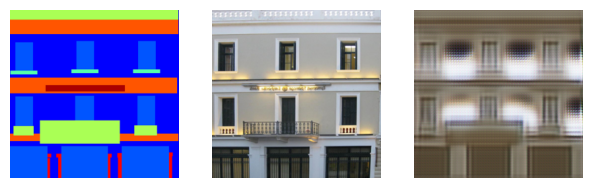

10 0.4777718186378479 3.480113983154297 0.0002 0.0002


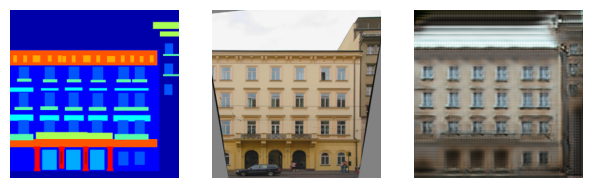

20 0.3904331624507904 4.483343601226807 0.0002 0.0002


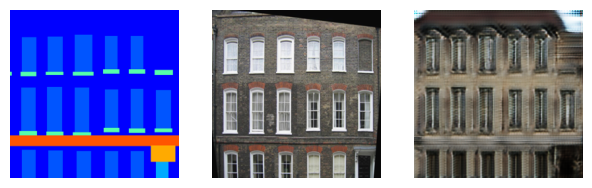

30 0.06576056778430939 3.738069534301758 0.0002 0.0002


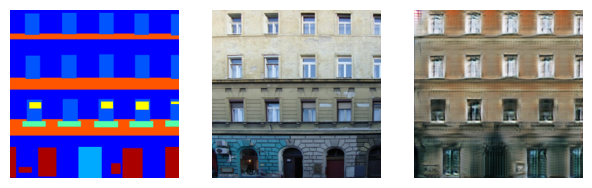

40 0.34224599599838257 3.628044366836548 0.0002 0.0002


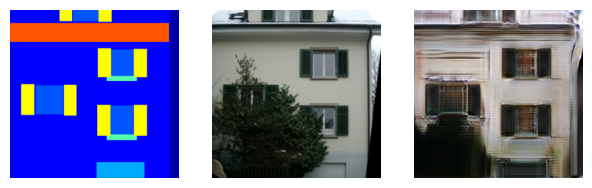

50 0.3070222735404968 5.867153644561768 0.0002 0.0002


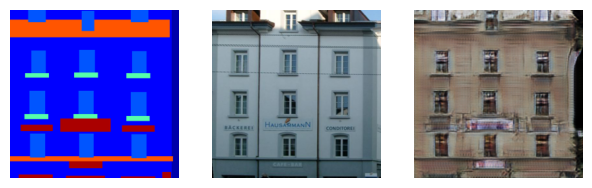

60 0.39033442735671997 2.990851879119873 0.0002 0.0002


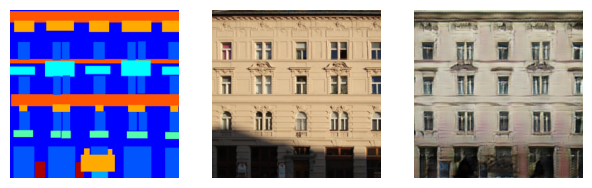

70 0.4855499863624573 2.7482247352600098 0.0002 0.0002


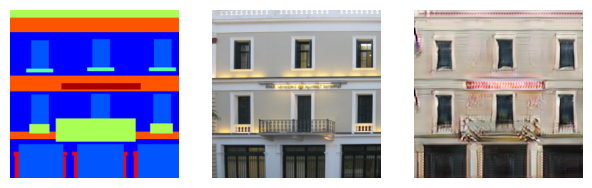

80 0.37947526574134827 3.7803101539611816 0.0002 0.0002


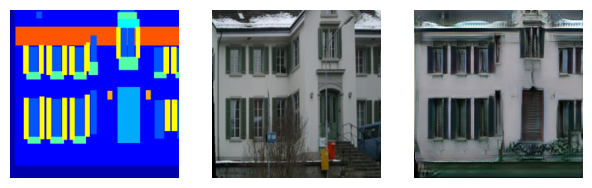

90 0.3920120298862457 3.066592216491699 0.0002 0.0002


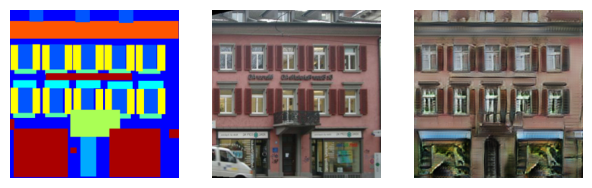

100 0.405597060918808 2.2805705070495605 0.0002 0.0002


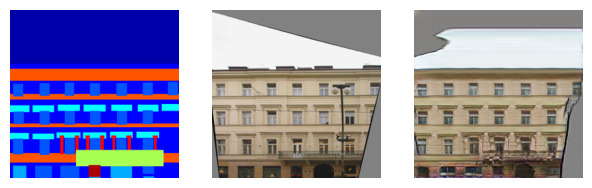

110 0.4005080759525299 2.4499385356903076 0.00018087641500176094 0.00018087641500176094


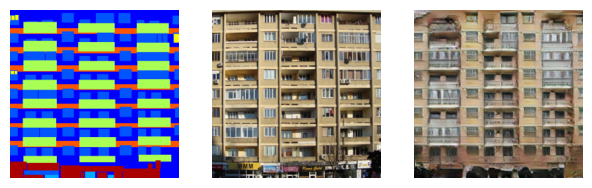

120 0.3772316873073578 2.3997154235839844 0.0001635813875194462 0.0001635813875194462


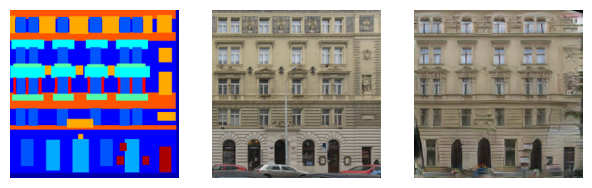

130 0.262306809425354 3.1333627700805664 0.0001479400746776561 0.0001479400746776561


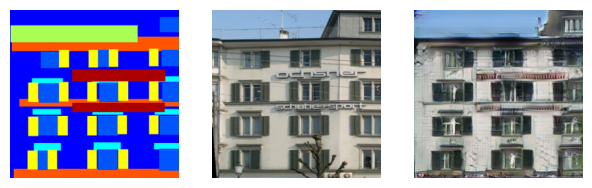

140 0.23527485132217407 2.6949076652526855 0.0001337943517139361 0.0001337943517139361


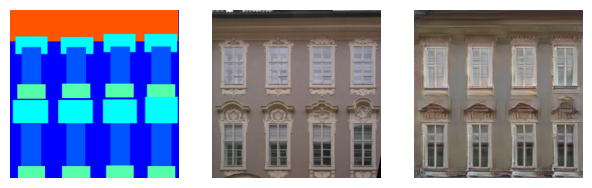

150 0.46737170219421387 2.169642925262451 0.00012100121342750732 0.00012100121342750732


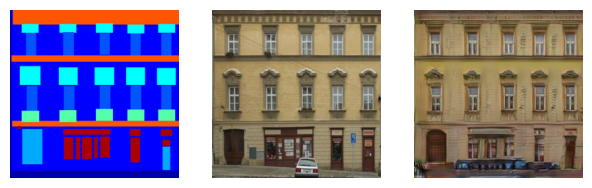

160 0.19557484984397888 2.45094633102417 0.0001094313284781523 0.0001094313284781523


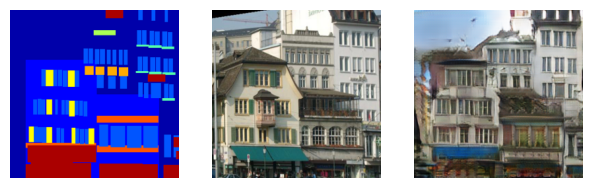

170 0.286415696144104 2.139770269393921 9.896773192004145e-05 9.896773192004145e-05


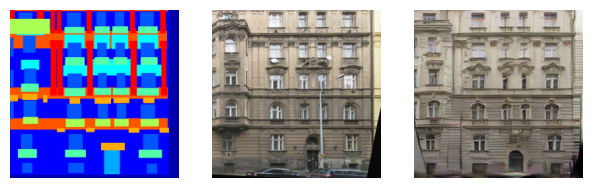

180 0.22644400596618652 2.790560245513916 8.950464275276218e-05 8.950464275276218e-05


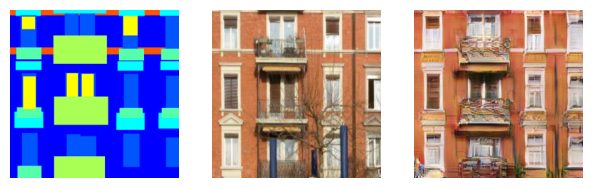

190 0.28030917048454285 2.4530763626098633 8.09463945356648e-05 8.09463945356648e-05


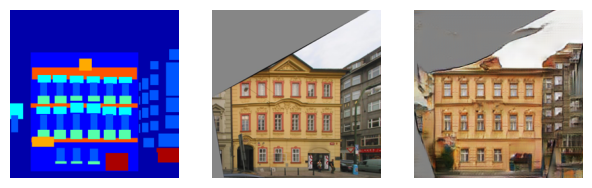

In [11]:
def train():
    for epoch in range(200):
        for _ in range(len(loader)):
            loss_cls = train_cls()
            loss_gen = train_gen()

        #N步以后再开始decay lr
        if epoch > 100:
            scheduler_gen.step()
            scheduler_cls.step()

        lr_gen = optimizer_gen.param_groups[0]['lr']
        lr_cls = optimizer_cls.param_groups[0]['lr']

        if epoch % 10 == 0:
            print(epoch, loss_cls, loss_gen, lr_gen, lr_cls)

            #取真数据
            #[1, 3, 256, 256]
            a_real, b_real = next(iter(loader))
            a_real = a_real.to(device)
            b_real = b_real.to(device)

            with torch.no_grad():
                #生成假图
                #[1, 3, 256, 256]
                b_fake = gen(a_real)

            show(torch.cat((a_real, b_real, b_fake), dim=0))


local_training = True

if local_training:
    train()

In [12]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.cls = cls.to('cpu')
        self.gen = gen.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.11.pix2pix',
        use_auth_token=open('/root/hub_token.txt').read().strip())

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/56.7M [00:00<?, ?B/s]

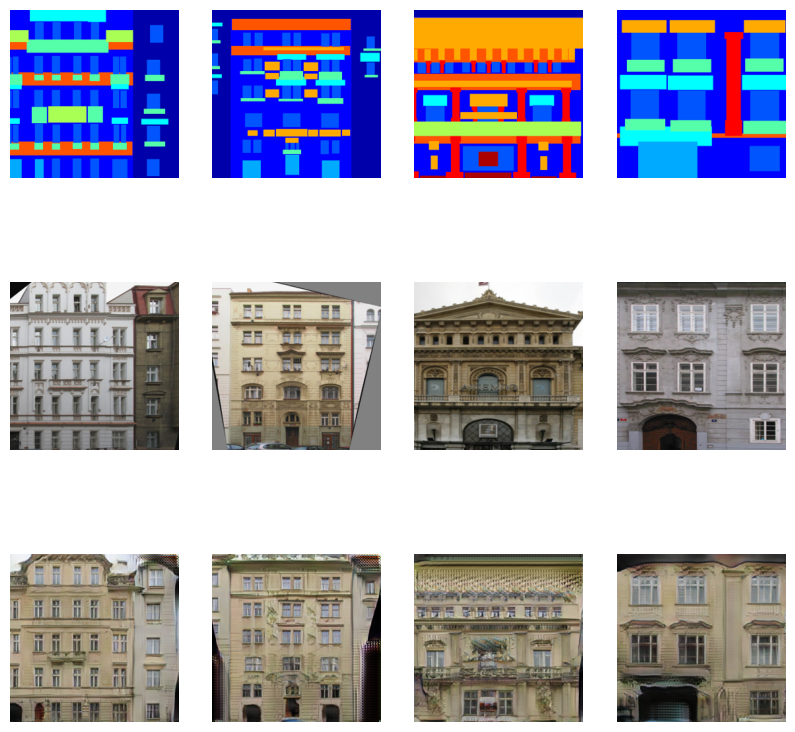

In [13]:
#加载训练好的模型
gen = Model.from_pretrained('lansinuote/gen.11.pix2pix').gen

#测试集
loader = torch.utils.data.DataLoader(dataset=Dataset('test'),
                                     batch_size=4,
                                     shuffle=True)

#取真数据
#[2, 3, 256, 256]
a_real, b_real = next(iter(loader))

with torch.no_grad():
    #生成假图
    #[1, 3, 256, 256]
    b_fake = gen(a_real)

show(torch.cat((a_real, b_real, b_fake), dim=0))